# FDA Warning Letter Analysis: Root Cause Investigation Deficiencies

**Research Question:** How frequently do FDA Warning Letters to pharmaceutical and medical device manufacturers cite inadequate root cause analysis?

**Data Source:** FDA Warning Letters Database (2022-2025), filtered to pharmaceutical and medical device manufacturing.

**Repository:** [github.com/auxiliary-machines/fda-warning-letter-analysis](https://github.com/auxiliary-machines/fda-warning-letter-analysis)

## Data Loading

Load the FDA Warning Letters index exported from FDA.gov.

In [1]:
import pandas as pd

df = pd.read_excel("data/fda-warning-letters.xlsx")
df.head()

,Posted Date,Letter Issue Date,Company Name,Issuing Office,Subject,Response Letter,Closeout Letter
0,07/26/2022,07/05/2022,"Bolive, Inc.",Division of West Coast Imports,Foreign Supplier Verification Program (FSVP),NaN,NaN
1,07/26/2022,06/30/2022,Bi-Coastal Pharma International,Office of Pharmaceutical Quality Operations Di...,CGMP/Finished Pharmaceuticals/Adulterated,NaN,NaN
2,07/26/2022,07/14/2022,"Daniel Fred Goodman, M.D./Goodman Eye Center",Center for Drug Evaluation and Research | CDER,Bioresearch Monitoring Program/Institutional R...,NaN,NaN
3,07/26/2022,07/15/2022,Blackout Vapors Inc.,Center for Tobacco Products,Family Smoking Prevention and Tobacco Control ...,NaN,NaN
4,07/26/2022,07/15/2022,"M & K On Cumberland, Inc. dba Big Cloud Vape &...",Center for Tobacco Products,Family Smoking Prevention and Tobacco Control ...,NaN,NaN


## Filtering Criteria

Filter to manufacturing quality violations. Exclude food, tobacco, cosmetics, clinical trials, and import violations.

**Included:** CGMP violations for finished pharmaceuticals, APIs, medical devices, biologics.

**Included Offices:** CDER, CDRH, CBER, Pharmaceutical Quality Operations divisions.

In [2]:
subject = [
    "CGMP/Finished Pharmaceuticals/Adulterated",
    "CGMP/Active Pharmaceutical Ingredient (API)/Adulterated",
    "CGMP/QSR/Medical Devices/Adulterated",
    "CGMP/QSR/Medical Devices/Adulterated/Misbranded",
    "CGMP/QSR/Medical Devices/PMA/Adulterated",
    "CGMP/QSR/Medical Devices/PMA/Adulterated/Misbranded",
    "CGMP/QSR/Drug/Medical Devices/Adulterated",
    "CGMP/QSR/Manufacture/Packing/Storage/Installation/Adulterated",
    "CGMP/Finished Pharmaceuticals/Adulterated/Misbranded",
    "CGMP/Finished Pharmaceutical/Adulterated",
    "CGMP/Finished Pharmaceutical/API/Adulterated",
    "CGMP/Drugs/Adulterated",
    "CGMP/Drug Products/Adulterated",
    "CGMP Deviations",
    "CGMP/Deviations/Biologics License Application (BLA)",
]

relevant_offices = [
    "Center for Drug Evaluation and Research | CDER",
    "Center for Drug Evaluation and Research (CDER)",
    "Center for Drug Evaluation and Research",
    "Center for Devices and Radiological Health",
    "Center for Biologics Evaluation and Research (CBER)",
    "Center for Biologics Evaluation and Research",
    "Division of Pharmaceutical Quality Operations I",
    "Division of Pharmaceutical Quality Operations II",
    "Division of Pharmaceutical Quality Operations III",
    "Division of Pharmaceutical Quality Operations IV",
    "Division of Pharmaceutical Quality Operations Division III",
    "Pharmaceutical Quality Operations Division III",
    "Division Pharmaceutical Quality Operations I",
    "Office of Pharmaceutical Quality Operations Division I",
    "Office of Pharmaceutical Quality Operations, Division II",
    "Office of Pharmaceutical Quality Operations",
    "Office of Pharmaceutical Quality",
    "Office of Manufacturing Quality",
    "Office of Medical Devices and Radiological Health Operations Div. 1 East",
    "Office of Medical Devices and Radiological Health Operations Div. 2 Central",
    "Office of Medical Devices and Radiological Health, Division 3",
    "Office of Medical Device and Radiological Health Division 3",
    "Office of Medical Device and Radiological Health Division 1 – East",
    "Office of Medical Device and Radiological Health, Division 3",
    "Office of Medical Device and Radiological Health Division I",
    "Office of Medical Device and Radiological Health Operations (Division 1)",
    "Division of Medical Device and Radiological Health Operations West",
    "Division of Medical Device and Radiological Health Operations Central",
    "Division of Medical Device and Radiological Health Operations East",
    "Division of Medical Device and Radiological Health Division I",
    "Office of Biological Products Operations – Division I",
    "Office of Biological Products Operations – Division 2",
    "Office of Biological Products Operations - Division 2",
    "Office Biological Products Operations – Division 2",
    "Division of Biological Products Operations I",
    "Division of Biological Products Operations II",
]

In [3]:
filtered_df = df[df['Issuing Office'].isin(relevant_offices) & df['Subject'].isin(subject)]
company_names = filtered_df['Company Name'].unique().tolist()

## Letter Retrieval

Fetch full HTML content of each Warning Letter for text analysis.

In [4]:
import requests
import pandas as pd
import time
import random
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm  # Specialized version for Jupyter
import os

FILE_NAME = "data/fda_all_warning_letters.csv"
AJAX_URL = "https://www.fda.gov/datatables/views/ajax"

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/121.0.0.0 Safari/537.36",
    "X-Requested-With": "XMLHttpRequest"
}

def get_all_fda_data():
    session = requests.Session()
    session.headers.update(headers)
    
    initial_params = {
        "view_name": "warning_letter_solr_index",
        "view_display_id": "warning_letter_solr_block",
        "start": 0,
        "length": 1, 
        "_drupal_ajax": 1
    }
    
    try:
        res = session.get(AJAX_URL, params=initial_params)
        total_records = int(res.json().get('recordsTotal', 3300))
        print(f"Server reports {total_records} total entries.")
    except Exception as e:
        print(f"Could not detect total records: {e}")
        total_records = 3300

    all_data = []
    batch_size = 100
    
    pbar = tqdm(total=total_records, desc="Scraping FDA Letters")

    for start in range(0, total_records, batch_size):
        params = {
            "view_name": "warning_letter_solr_index",
            "view_display_id": "warning_letter_solr_block",
            "start": start,
            "length": batch_size,
            "_drupal_ajax": 1
        }

        try:
            response = session.get(AJAX_URL, params=params, timeout=20)
            rows = response.json().get('data', [])

            for row in rows:
                soup = BeautifulSoup(row[2], "html.parser")
                a_tag = soup.find('a')
                
                all_data.append({
                    "Posted Date": row[0],
                    "Letter Issue Date": row[1],
                    "Company Name": soup.get_text(strip=True),
                    "Warning Letter URL": f"https://www.fda.gov{a_tag['href']}" if a_tag else "N/A",
                    "Issuing Office": row[3],
                    "Subject": row[4]
                })

            pbar.update(len(rows))
            
            # Rate limiting delay
            time.sleep(random.uniform(2, 4))

        except Exception as e:
            print(f"\nStopped at {start} due to error: {e}")
            break
            
    pbar.close()

    df = pd.DataFrame(all_data)
    df.to_csv(FILE_NAME, index=False)
    print(f"Success! {len(df)} records saved to {FILE_NAME}.")
    return df

if not os.path.exists(FILE_NAME):
    df_master = get_all_fda_data()
else:
    print(f"{FILE_NAME} already exists")

data/fda_all_warning_letters.csv already exists


In [5]:
import os
import pandas as pd

# Ensure the output directory exists
output_dir = 'data/letters'
os.makedirs(output_dir, exist_ok=True)

# Load the warning letters data
df = pd.read_csv('data/fda_all_warning_letters.csv')

# Filter for the specified company names
target_df = df[df['Company Name'].isin(company_names)]

# Use tqdm for a progress bar while iterating through the target dataframe
for idx, row in tqdm(target_df.iterrows(), total=len(target_df), desc="Fetching letters"):
    company_name = row['Company Name']
    url = row['Warning Letter URL']
    
    # Sanitize filename and include index to avoid overwriting multiple letters for the same company
    safe_filename = "".join([c for c in str(company_name) if c.isalnum() or c in (' ', '.', '_', '-')]).strip()
    file_path = os.path.join(output_dir, f"{safe_filename}_{idx}.html")
    
    if not os.path.exists(file_path):
        try:
            # Use headers to mock browser agent
            response = requests.get(url, timeout=10, headers=headers)
            response.raise_for_status()
            
            with open(file_path, 'w', encoding='utf-8') as f:
                f.write(response.text)
            
            # Rate limiting
            time.sleep(1)
        except Exception as e:
            tqdm.write(f"Could not fetch {url} for {company_name}: {e}")

Fetching letters:   0%|          | 0/417 [00:00<?, ?it/s]

In [6]:
def extract_fda_letter_content(html_content):
    soup = BeautifulSoup(html_content, "html.parser")

    # The main content is typically within a div with class 'col-md-8' and role 'main'
    # within the 'main-content' article.
    main_div = soup.find("div", {"role": "main", "class": "col-md-8"})

    if not main_div:
        # Fallback to the article tag if the specific div isn't found
        main_div = soup.find("article", id="main-content")

    if not main_div:
        return "Could not find main content."

    # Optionally, we can remove scripts, styles, and certain structural elements if needed
    for element in main_div(["script", "style", "aside", "nav"]):
        element.decompose()

    # Get the text. Use separator='\n' to preserve some distance between paragraphs.
    text = main_div.get_text(separator="\n", strip=True)

    return text


html_files = [f for f in os.listdir(output_dir) if f.endswith(".html")]
# Maps the html file name against the extracted contents of the letter.
html_content_map: dict[str, str] = {}

for html_f in html_files:
    file_path = os.path.join(output_dir, html_f)
    if os.path.exists(file_path):
        with open(file_path, "r", encoding="utf-8") as f:
            content = f.read()
            letter_text = extract_fda_letter_content(content)
            html_content_map[html_f] = letter_text

## Category Classification

Classify RCA-related letters by failure mode:

| Category | Definition |
|----------|------------|
| No investigation conducted | Company did not investigate at all |
| Investigation was inadequate | Investigation was superficial or incomplete |
| Root cause not identified | Did not determine the true underlying cause |
| CAPA did not address root cause | Corrective action didn't fix the identified cause |

In [7]:
import re

rca_categories = {
    "No investigation conducted": [
        r"no investigation",
        r"without.{0,20}investigat",
        r"fail(ed|ure)? to.{0,10}investigate",
        r"did not.{0,10}investigate",
    ],
    "Investigation was inadequate": [
        r"inadequate investigation",
        r"investigation.{0,20}(inadequate|insufficient|incomplete|limited)",
        r"investigation did not.{0,30}(determine|identify|address|consider)",
        r"fail(ed|ure)? to adequately investigate",
    ],
    "Root cause not identified": [
        r"did not (determine|identify).{0,20}(root |underlying )?cause",
        r"fail(ed|ure)? to (determine|identify).{0,20}(root |underlying )?cause",
        r"(root|underlying) cause.{0,20}not (identified|determined|established)",
        r"without.{0,20}(root|underlying) cause",
        r"root cause",
    ],
    "CAPA did not address root cause": [
        r"corrective action(s)?.{0,30}(did not|failed to).{0,20}address",
        r"capa.{0,30}(did not|failed to|inadequate)",
        r"preventive action(s)?.{0,30}(did not|failed to)",
    ],
}

def categorize_letter(content):
    hits = {}
    for category, patterns in rca_categories.items():
        for p in patterns:
            if re.search(p, content, re.IGNORECASE):
                hits[category] = True
                break
    return hits

# Classify all letters
results = []
for filename, content in html_content_map.items():
    cats = categorize_letter(content)
    results.append({
        "filename": filename,
        "has_rca": len(cats) > 0,
        **{cat: cat in cats for cat in rca_categories.keys()}
    })

df_cat = pd.DataFrame(results)

# Core metrics (use these everywhere)
TOTAL_LETTERS = len(df_cat)
RCA_LETTERS = df_cat['has_rca'].sum()
RCA_PCT = RCA_LETTERS / TOTAL_LETTERS * 100

print(f"Total letters analyzed: {TOTAL_LETTERS}")
print(f"RCA-related: {RCA_LETTERS} ({RCA_PCT:.1f}%)")
print()
for cat in rca_categories.keys():
    count = df_cat[cat].sum()
    pct = count / TOTAL_LETTERS * 100
    print(f"{count:3d} ({pct:5.1f}%) - {cat}")

# Define flagged list for downstream use (LLM, plots)
flagged = df_cat[df_cat['has_rca']]['filename'].tolist()

Total letters analyzed: 417
RCA-related: 200 (48.0%)

 51 ( 12.2%) - No investigation conducted
 67 ( 16.1%) - Investigation was inadequate
180 ( 43.2%) - Root cause not identified
 26 (  6.2%) - CAPA did not address root cause


## Manual Validation

In [8]:
# Manual validation, check the following htmls.
flagged = df_cat[df_cat['has_rca']]['filename'].tolist()
not_flagged = df_cat[~df_cat['has_rca']]['filename'].tolist()

print("=== FLAGGED (should mention RCA failures) ===")
for f in random.sample(flagged, 5):
    print(f)

print("\n=== NOT FLAGGED (should NOT be about RCA) ===")
for f in random.sample(not_flagged, 5):
    print(f)

=== FLAGGED (should mention RCA failures) ===
GFA Production Xiamen Co. Ltd._1070.html
LiquidCapsule Manufacturing LLC_22.html
Creative Essences Inc._193.html
Zyno Medical LLC_2193.html
Sircle Laboratories LLC_2762.html

=== NOT FLAGGED (should NOT be about RCA) ===
National Chemical Laboratories_1387.html
Yangzhou Yulou Paper Products Co. Ltd._261.html
Integrity Partners Group_8.html
Gulsah Uretim Kozmetik Sanayi Anonim Sirketi_2859.html
ASP Global LLC. dba Anatomy Supply Partners LLC._16.html


## LLM-Assisted Extraction

Using Gemma 3 (4B) via Ollama to extract from each letter:
- **Product type** — What the company manufactures
- **Defect** — The quality problem that triggered the letter
- **Claimed cause** — The root cause the company proposed
- **FDA critique** — Why FDA found the investigation inadequate

In [9]:
import ollama
import random
import json
from tqdm import tqdm

model = "gemma3:4b"

prompt_claimed_cause = """This FDA Warning Letter describes a company's failed investigation. 

What explanation or root cause did THE COMPANY provide for the quality failure?

Look for phrases like:
- "Your firm attributed the failure to..."
- "You concluded that..."
- "Your investigation determined..."
- "The root cause was identified as..."
- "You stated the cause was..."

Good examples of company-claimed causes:
- "Operator error during batch preparation"
- "Equipment malfunction in filling line"
- "Raw material contamination from supplier"
- "Training deficiency"
- "Calibration drift in analytical equipment"
- "Environmental excursion during storage"

If the company blamed human/operator error, say exactly what they blamed.
If the company did not identify any cause, respond: NONE IDENTIFIED
If the letter doesn't mention what the company claimed, respond: NOT STATED

Respond in 5-15 words only. No explanation.

Letter excerpt:
{content}"""

prompt_defect = """What specific quality PROBLEM triggered this FDA Warning Letter?

Focus on the PRODUCT FAILURE, not the investigation failure.

Examples:
- "Particulate contamination in injectable vials"
- "Failed sterility test - microbial growth detected"
- "Out-of-specification dissolution results for tablets"
- "Cracked vial stoppers"
- "Subpotent API concentration"
- "Failed media fill - contaminated units"
- "Device malfunction during use"

Respond with ONLY the product defect in 5-15 words.
If no specific defect is mentioned, respond: NOT SPECIFIED

Letter excerpt:
{content}"""

prompt_product_type = """Classify this FDA Warning Letter into ONE product category based on what the company manufactures.

Categories:
- Injectable drugs (vials, syringes, IV solutions, vaccines)
- Oral solid dosage (tablets, capsules, pills)
- Sterile products (eye drops, surgical solutions, implants)
- Medical devices (syringes, catheters, diagnostic equipment, surgical instruments)
- Active pharmaceutical ingredients (API) (raw drug substances, chemical intermediates)
- Biologics (blood products, cell therapies, monoclonal antibodies)
- Topical products (creams, ointments, gels, patches)
- Ophthalmic products (eye drops, contact lens solutions)
- Combination products (drug-device combinations, prefilled syringes)

If the product doesn't fit any category or is unclear, respond: Other

Respond with ONLY the category name, nothing else.

Letter excerpt:
{content}"""

prompt_fda_critique = """What SPECIFIC criticism did FDA make about why the company's investigation was inadequate?

Look for FDA saying things like:
- "Your investigation failed to..."
- "You did not adequately..."
- "The investigation lacked..."
- "Your firm did not consider..."

Extract the core criticism in ONE sentence. Focus on the GAP or FAILURE.

Examples of good responses:
- "Failed to consider all potential sources of contamination"
- "Did not extend investigation to other potentially affected batches"
- "Lacked scientific justification for concluding operator error"
- "Did not evaluate whether the issue was systemic"

If unclear, respond: NOT SPECIFIED

Respond with ONE sentence only.

Letter excerpt:
{content}"""

# Get flagged letters from df_cat (uses rca_categories)
flagged = df_cat[df_cat['has_rca']]['filename'].tolist()

# Build combined pattern for excerpt extraction
all_patterns = []
for patterns in rca_categories.values():
    all_patterns.extend(patterns)
combined_pattern = re.compile("|".join(all_patterns), re.IGNORECASE)

# Load existing results if resuming
output_file = "data/llm_results.jsonl"
processed = set()
try:
    with open(output_file, 'r') as f:
        for line in f:
            result = json.loads(line)
            processed.add(result['filename'])
    print(f"Resuming: {len(processed)} already processed")
except FileNotFoundError:
    print("Starting fresh")

# Process with progress bar, skip already processed
with open(output_file, 'a') as f:
    for filename in tqdm(flagged, desc="Processing letters"):
        if filename in processed:
            continue
            
        content = html_content_map[filename]
        match = combined_pattern.search(content)
        if match:
            start = max(0, match.start() - 2000)
            end = min(len(content), match.end() + 2000)
            excerpt = content[start:end]
        else:
            # Fallback: use first 4000 chars if no match found
            excerpt = content[:4000]
        
        try:
            resp_defect = ollama.chat(model=model, messages=[
                {"role": "user", "content": prompt_defect.format(content=excerpt)}
            ])
            
            resp_cause = ollama.chat(model=model, messages=[
                {"role": "user", "content": prompt_claimed_cause.format(content=excerpt)}
            ])
            
            resp_product = ollama.chat(model=model, messages=[
                {"role": "user", "content": prompt_product_type.format(content=excerpt)}
            ])
            
            resp_critique = ollama.chat(model=model, messages=[
                {"role": "user", "content": prompt_fda_critique.format(content=excerpt)}
            ])
            
            result = {
                "filename": filename,
                "defect": resp_defect['message']['content'].strip(),
                "claimed_cause": resp_cause['message']['content'].strip(),
                "product_type": resp_product['message']['content'].strip(),
                "fda_critique": resp_critique['message']['content'].strip(),
            }
            
            # Write immediately (append mode)
            f.write(json.dumps(result) + '\n')
            f.flush()  # Ensure it's written
            
        except Exception as e:
            print(f"Error processing {filename}: {e}")
            continue

# Load all results into dataframe
llm_results = []
with open(output_file, 'r') as f:
    for line in f:
        llm_results.append(json.loads(line))

df_llm = pd.DataFrame(llm_results)
print(f"\nProcessed {len(df_llm)} letters")
df_llm.head(10)

Resuming: 200 already processed


Processing letters: 100%|██████████| 200/200 [00:00<00:00, 3039350.72it/s]


Processed 200 letters


,filename,defect,claimed_cause,product_type,fda_critique
0,Profounda Inc._1838.html,Lack of identity testing for diethylene glycol...,NONE IDENTIFIED,Oral solid dosage,Your firm failed to withhold each lot of compo...
1,Tianjin Bolang Science-Technology Development ...,Lack of design control procedures and activiti...,NONE IDENTIFIED,Medical devices,The firm’s response is not adequate because it...
2,Zyno Medical LLC_2193.html,Leaking administration sets with compromised f...,Device not returned; no cause established.,Medical devices,The investigation lacked a thorough evaluation...
3,Landy International_1068.html,NOT SPECIFIED,NONE IDENTIFIED,Active pharmaceutical ingredients (API),The investigation lacked a comprehensive asses...
4,Zydus Lifesciences Limited_928.html,Cross-contamination from inadequate cleaning o...,"Inadequate cleaning, shared equipment, and tes...",Drugs,Your investigation failed to adequately consid...
5,Becton Dickinson and CompanyCareFusion 303 Inc...,Delay in dispensing medications due to freezin...,Complaint investigations were not comprehensiv...,Other,Failed to adequately investigate and address a...
6,Zhejiang Tianyu Pharmaceutical Co. Ltd._2092.html,High impurity concentration in API batches.,"Operator error during batch preparation, equip...",Active pharmaceutical ingredients (API),Your investigation failed to extend its scope ...
7,Accra-Pac Inc. dba Voyant Beauty_1783.html,Benzene contamination in drug products at unac...,"Operator error during propellant blending, ina...",Topical products,Failed to thoroughly investigate any unexplain...
8,Argon Medical Productions Vertrieb Gesellscha...,Failure of dental implants to osseointegrate,Complaints due to patient-specific factors are...,Medical devices,Your firm failed to adequately investigate com...
9,Chemspec Chemicals Private Limited_20.html,Batch manufacturing records lacking complete i...,Operator error and deficient data integrity pr...,Active pharmaceutical ingredients (API),Your quality unit failed to investigate and co...


## Plots and Results

In [10]:
import matplotlib.pyplot as plt

# CONSTANTS (from category analysis)
TOTAL_LETTERS = len(df_cat)
RCA_LETTERS = df_cat["has_rca"].sum()
RCA_PCT = RCA_LETTERS / TOTAL_LETTERS * 100

# Category counts (pull dynamically, not hardcoded)
category_stats = []
for cat in rca_categories.keys():
    count = df_cat[cat].sum()
    category_stats.append(
        {"category": cat, "count": count, "pct": count / TOTAL_LETTERS * 100}
    )
df_category_stats = pd.DataFrame(category_stats)

print(f"Using: {TOTAL_LETTERS} total, {RCA_LETTERS} RCA-related ({RCA_PCT:.1f}%)")

Using: 417 total, 200 RCA-related (48.0%)


In [11]:
import re

# Create df_filtered from the CSV used for fetching letters
df_filtered = pd.read_csv('data/fda_all_warning_letters.csv')

# Add filename column to match df_cat
df_filtered['filename'] = df_filtered.apply(
    lambda row: f"{row['Company Name']}_{row.name}.html".replace('/', '_').replace('\\', '_'),
    axis=1
)

# Clean the date column - remove HTML tags if present
df_filtered['Letter Issue Date'] = df_filtered['Letter Issue Date'].astype(str).apply(
    lambda x: re.sub(r'<[^>]+>', '', x).strip()
)

# Parse dates with explicit format
df_filtered['year'] = pd.to_datetime(
    df_filtered['Letter Issue Date'], 
    format='%m/%d/%Y',
    errors='coerce'
).dt.year

print(f"df_filtered: {len(df_filtered)} rows")
print(f"Year range: {df_filtered['year'].min()} - {df_filtered['year'].max()}")
print(df_filtered[['filename', 'Letter Issue Date', 'year']].head())

df_filtered: 3277 rows
Year range: 2021 - 2026
                                  filename Letter Issue Date  year
0          Meridian Bioscience, Inc_0.html        12/22/2025  2025
1  Fulijaya Manufacturing SDN. BHD._1.html        01/14/2026  2026
2         MAST Biosurgery USA, Inc._2.html        12/17/2025  2025
3                      MG GROUP USA_3.html        10/23/2025  2025
4                   Asli Foods, Inc_4.html        11/25/2025  2025


Total: 417 | RCA-related: 200 (48.0%)


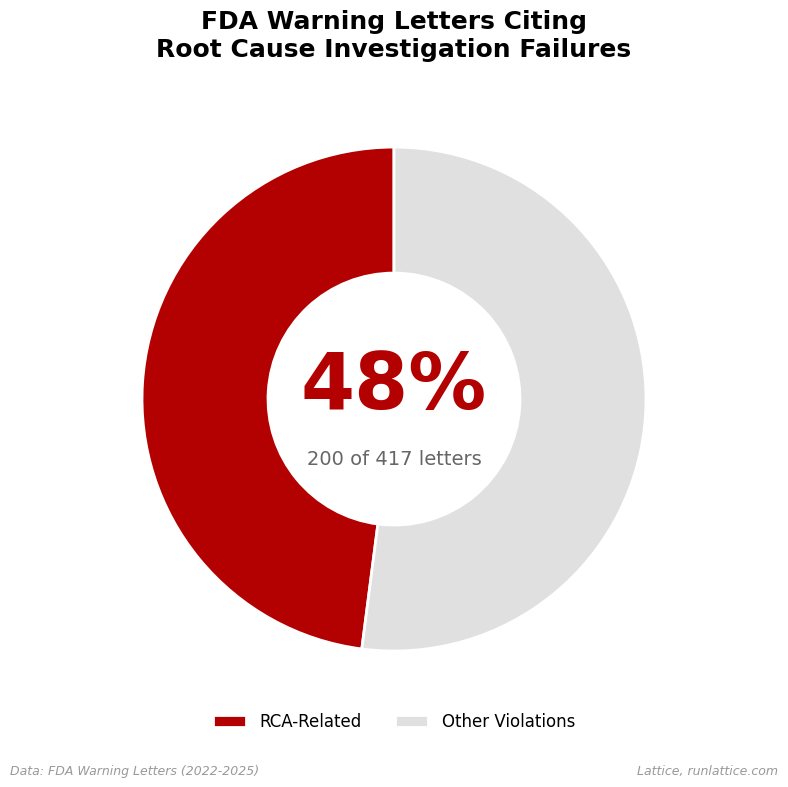

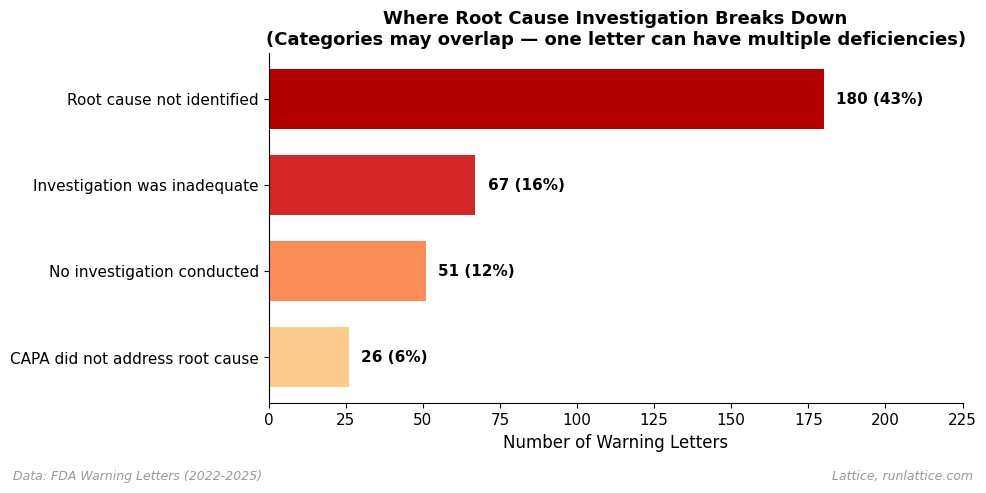

Letters for trend analysis: 222
   year  total  rca_count  non_rca     rca_pct
0  2021     19          8       11   42.105263
1  2022     38         25       13   65.789474
2  2023     51         25       26   49.019608
3  2024     52         23       29   44.230769
4  2025     61         32       29   52.459016
5  2026      1          1        0  100.000000


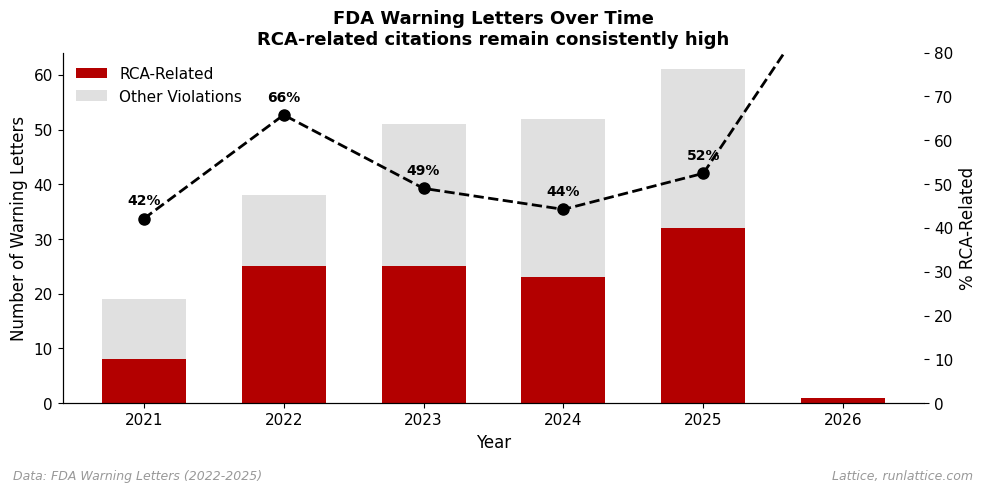

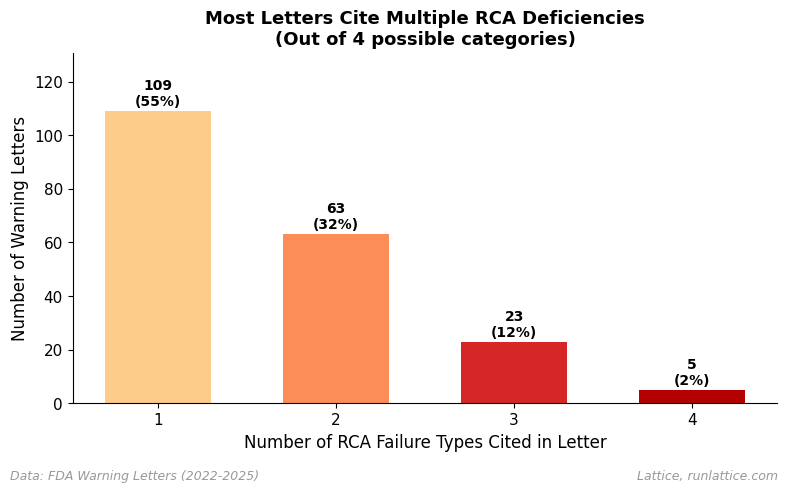

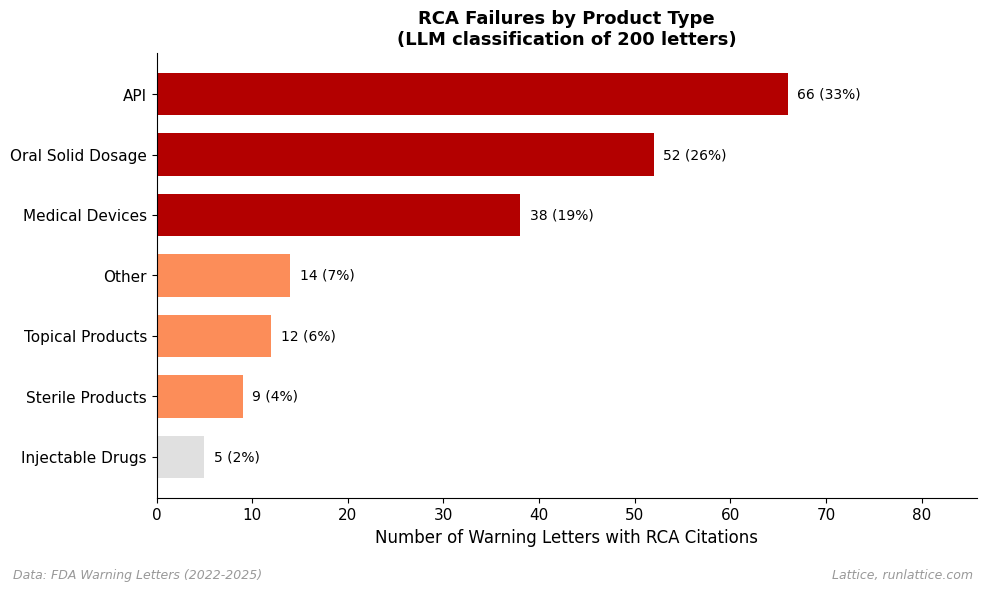

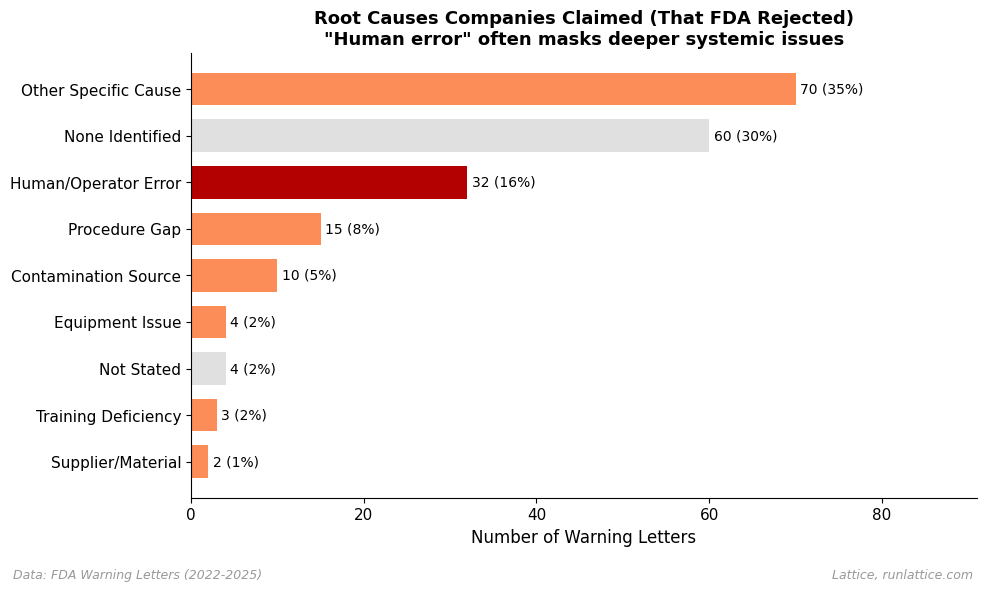

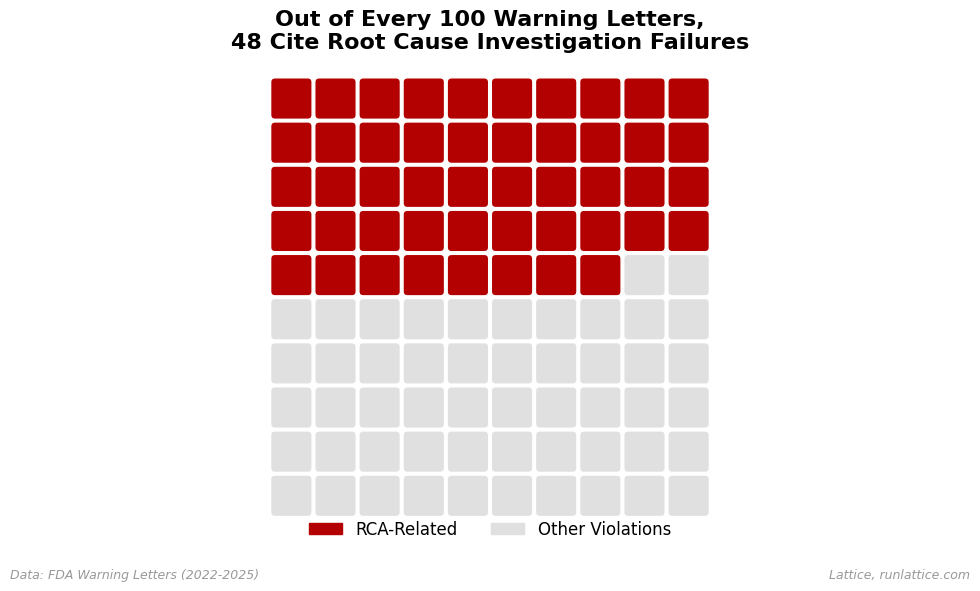

Summary exported to results/summary.json
{
  "analysis_date": "January 2025",
  "data_range": "July 2022 - January 2025",
  "total_letters_analyzed": 417,
  "rca_related_count": 200,
  "rca_related_percentage": 48.0,
  "categories": {
    "No investigation conducted": {
      "count": 51,
      "percentage": 12.2
    },
    "Investigation was inadequate": {
      "count": 67,
      "percentage": 16.1
    },
    "Root cause not identified": {
      "count": 180,
      "percentage": 43.2
    },
    "CAPA did not address root cause": {
      "count": 26,
      "percentage": 6.2
    }
  },
  "llm_processed": 200
}


In [28]:
import matplotlib.patches as mpatches
import os

# Create output directory
os.makedirs("results/figures", exist_ok=True)

# Set consistent style
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = 11
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False


# Watermark helper
def add_watermark(fig):
    # Data source on the left
    fig.text(
        0.02,
        0.02,
        "Data: FDA Warning Letters (2022-2025)",
        ha="left",
        va="bottom",
        fontsize=9,
        color="#999999",
        style="italic",
    )
    # Brand on the right
    fig.text(
        0.98,
        0.02,
        "Lattice, runlattice.com",
        ha="right",
        va="bottom",
        fontsize=9,
        color="#999999",
        style="italic",
    )


# CONSTANTS (from category analysis)
TOTAL_LETTERS = len(df_cat)
RCA_LETTERS = int(df_cat["has_rca"].sum())
RCA_PCT = RCA_LETTERS / TOTAL_LETTERS * 100

# Category counts
category_stats = []
for cat in rca_categories.keys():
    count = int(df_cat[cat].sum())
    category_stats.append(
        {"category": cat, "count": count, "pct": count / TOTAL_LETTERS * 100}
    )
df_category_stats = pd.DataFrame(category_stats)

# Colors
COLOR_PRIMARY = "#b30000"
COLOR_SECONDARY = "#d62728"
COLOR_TERTIARY = "#fc8d59"
COLOR_LIGHT = "#fdcc8a"
COLOR_GRAY = "#e0e0e0"

print(f"Total: {TOTAL_LETTERS} | RCA-related: {RCA_LETTERS} ({RCA_PCT:.1f}%)")

# PLOT 1: Headline Finding — Donut Chart
# The key finding that anchors the entire analysis

fig, ax = plt.subplots(figsize=(8, 8))

sizes = [RCA_LETTERS, TOTAL_LETTERS - RCA_LETTERS]
colors = [COLOR_PRIMARY, COLOR_GRAY]

wedges, _ = ax.pie(
    sizes,
    colors=colors,
    startangle=90,
    wedgeprops=dict(width=0.5, edgecolor="white", linewidth=2),
)

# Center text
ax.text(
    0,
    0.05,
    f"{RCA_PCT:.0f}%",
    ha="center",
    va="center",
    fontsize=56,
    fontweight="bold",
    color=COLOR_PRIMARY,
)
ax.text(
    0,
    -0.2,
    f"{RCA_LETTERS} of {TOTAL_LETTERS} letters",
    ha="center",
    va="top",
    fontsize=14,
    color="#666666",
)

ax.set_title(
    "FDA Warning Letters Citing\nRoot Cause Investigation Failures",
    fontsize=18,
    fontweight="bold",
    pad=20,
)

# Legend
ax.legend(
    wedges,
    ["RCA-Related", "Other Violations"],
    loc="lower center",
    bbox_to_anchor=(0.5, -0.05),
    ncol=2,
    fontsize=12,
    frameon=False,
)

add_watermark(fig)
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig(
    "results/figures/01_headline_donut.png",
    dpi=150,
    bbox_inches="tight",
    facecolor="white",
    edgecolor="none",
)
plt.show()

# PLOT 2: Category Breakdown — Where Investigation Fails
# Shows the four failure modes, sorted by frequency

fig, ax = plt.subplots(figsize=(10, 5))

df_plot = df_category_stats.sort_values("count", ascending=True)
colors_cat = [COLOR_LIGHT, COLOR_TERTIARY, COLOR_SECONDARY, COLOR_PRIMARY]

bars = ax.barh(df_plot["category"], df_plot["count"], color=colors_cat, height=0.7)

ax.set_xlabel("Number of Warning Letters", fontsize=12)
ax.set_title(
    "Where Root Cause Investigation Breaks Down\n(Categories may overlap — one letter can have multiple deficiencies)",
    fontsize=13,
    fontweight="bold",
)

# Add count labels
for i, (idx, row) in enumerate(df_plot.iterrows()):
    ax.text(
        row["count"] + 4,
        i,
        f"{row['count']} ({row['pct']:.0f}%)",
        va="center",
        fontsize=11,
        fontweight="bold",
    )

ax.set_xlim(0, df_plot["count"].max() * 1.25)
add_watermark(fig)
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig(
    "results/figures/02_category_breakdown.png",
    dpi=150,
    bbox_inches="tight",
    facecolor="white",
    edgecolor="none",
)
plt.show()

# PLOT 3: Year-over-Year Trend
# Shows whether the problem is getting better or worse

# Get dates from the CSV used for fetching
df_all = pd.read_csv("data/fda_all_warning_letters.csv")

# Create filename column to match df_cat
df_all["filename"] = df_all.apply(
    lambda row: f"{row['Company Name']}_{row.name}.html".replace("/", "_").replace(
        "\\", "_"
    ),
    axis=1,
)

# Only keep letters that are in df_cat (the 417 we analyzed)
df_analysis = df_all[df_all["filename"].isin(df_cat["filename"])].copy()

# Merge RCA flag
filename_to_rca = dict(zip(df_cat["filename"], df_cat["has_rca"]))
df_analysis["has_rca"] = df_analysis["filename"].map(filename_to_rca)

# Clean dates
df_analysis["Letter Issue Date"] = (
    df_analysis["Letter Issue Date"]
    .astype(str)
    .apply(lambda x: re.sub(r"<[^>]+>", "", x).strip())
)
df_analysis["year"] = pd.to_datetime(
    df_analysis["Letter Issue Date"], format="%m/%d/%Y", errors="coerce"
).dt.year

print(f"Letters for trend analysis: {len(df_analysis)}")

# Aggregate by year
yearly = (
    df_analysis.groupby("year")
    .agg(total=("has_rca", "count"), rca_count=("has_rca", "sum"))
    .reset_index()
)
yearly = yearly.dropna()
yearly["non_rca"] = yearly["total"] - yearly["rca_count"]
yearly["rca_pct"] = yearly["rca_count"] / yearly["total"] * 100

print(yearly)

# Plot
fig, ax1 = plt.subplots(figsize=(10, 5))

width = 0.6
ax1.bar(
    yearly["year"], yearly["rca_count"], width, label="RCA-Related", color=COLOR_PRIMARY
)
ax1.bar(
    yearly["year"],
    yearly["non_rca"],
    width,
    bottom=yearly["rca_count"],
    label="Other Violations",
    color=COLOR_GRAY,
)

ax1.set_xlabel("Year", fontsize=12)
ax1.set_ylabel("Number of Warning Letters", fontsize=12)
ax1.set_title(
    "FDA Warning Letters Over Time\nRCA-related citations remain consistently high",
    fontsize=13,
    fontweight="bold",
)
ax1.legend(loc="upper left", frameon=False)
ax1.set_xticks(yearly["year"].astype(int))

ax2 = ax1.twinx()
ax2.plot(
    yearly["year"],
    yearly["rca_pct"],
    color="black",
    marker="o",
    linewidth=2,
    markersize=8,
    linestyle="--",
)
ax2.set_ylabel("% RCA-Related", fontsize=12)
ax2.set_ylim(0, 80)

for _, row in yearly.iterrows():
    ax2.annotate(
        f"{row['rca_pct']:.0f}%",
        xy=(row["year"], row["rca_pct"]),
        xytext=(0, 10),
        textcoords="offset points",
        ha="center",
        fontsize=10,
        fontweight="bold",
    )

add_watermark(fig)
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig(
    "results/figures/03_year_trend.png",
    dpi=150,
    bbox_inches="tight",
    facecolor="white",
    edgecolor="none",
)
plt.show()
# PLOT 4: Multiple Deficiencies per Letter
# Shows that RCA failures are often compound problems

df_cat["num_categories"] = df_cat[list(rca_categories.keys())].sum(axis=1)
overlap_counts = df_cat[df_cat["has_rca"]]["num_categories"].value_counts().sort_index()

fig, ax = plt.subplots(figsize=(8, 5))

colors_overlap = [COLOR_LIGHT, COLOR_TERTIARY, COLOR_SECONDARY, COLOR_PRIMARY][
    : len(overlap_counts)
]
bars = ax.bar(
    overlap_counts.index, overlap_counts.values, color=colors_overlap, width=0.6
)

ax.set_xlabel("Number of RCA Failure Types Cited in Letter", fontsize=12)
ax.set_ylabel("Number of Warning Letters", fontsize=12)
ax.set_title(
    "Most Letters Cite Multiple RCA Deficiencies\n(Out of 4 possible categories)",
    fontsize=13,
    fontweight="bold",
)
ax.set_xticks(overlap_counts.index)

# Add count labels
for i, (idx, val) in enumerate(overlap_counts.items()):
    pct = val / RCA_LETTERS * 100
    ax.text(
        idx,
        val + 2,
        f"{val}\n({pct:.0f}%)",
        ha="center",
        fontsize=10,
        fontweight="bold",
    )

ax.set_ylim(0, overlap_counts.max() * 1.2)
add_watermark(fig)
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig(
    "results/figures/04_category_overlap.png",
    dpi=150,
    bbox_inches="tight",
    facecolor="white",
    edgecolor="none",
)
plt.show()

# PLOT 5: Product Type Distribution (from LLM)
# Which product categories have the most RCA failures

# Load LLM results if not already loaded
if "df_llm" not in dir() or len(df_llm) == 0:
    llm_results = []
    with open("data/llm_results.jsonl", "r") as f:
        for line in f:
            llm_results.append(json.loads(line))
    df_llm = pd.DataFrame(llm_results)


# Normalize product types
def normalize_product_type(pt):
    if pd.isna(pt):
        return "Other"
    pt_lower = pt.lower().strip()
    if "injectable" in pt_lower:
        return "Injectable Drugs"
    if "oral" in pt_lower or "tablet" in pt_lower or "capsule" in pt_lower:
        return "Oral Solid Dosage"
    if "device" in pt_lower:
        return "Medical Devices"
    if "api" in pt_lower or "active pharmaceutical" in pt_lower:
        return "API"
    if "biologic" in pt_lower:
        return "Biologics"
    if "sterile" in pt_lower:
        return "Sterile Products"
    if "topical" in pt_lower:
        return "Topical Products"
    if "ophthalmic" in pt_lower:
        return "Ophthalmic"
    if "combination" in pt_lower:
        return "Combination Products"
    if "other" in pt_lower:
        return "Other"
    return "Other"


df_llm["product_type_clean"] = df_llm["product_type"].apply(normalize_product_type)
product_counts = df_llm["product_type_clean"].value_counts()

# Only show categories with meaningful counts
product_counts = product_counts[product_counts >= 3]

fig, ax = plt.subplots(figsize=(10, 6))

colors_prod = [
    COLOR_PRIMARY if i < 3 else COLOR_TERTIARY if i < 6 else COLOR_GRAY
    for i in range(len(product_counts))
]

ax.barh(
    product_counts.index[::-1],
    product_counts.values[::-1],
    color=colors_prod[::-1],
    height=0.7,
)

ax.set_xlabel("Number of Warning Letters with RCA Citations", fontsize=12)
ax.set_title(
    f"RCA Failures by Product Type\n(LLM classification of {len(df_llm)} letters)",
    fontsize=13,
    fontweight="bold",
)

for i, (name, count) in enumerate(
    zip(product_counts.index[::-1], product_counts.values[::-1])
):
    pct = count / len(df_llm) * 100
    ax.text(count + 1, i, f"{count} ({pct:.0f}%)", va="center", fontsize=10)

ax.set_xlim(0, product_counts.max() * 1.3)
add_watermark(fig)
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig(
    "results/figures/05_product_type.png",
    dpi=150,
    bbox_inches="tight",
    facecolor="white",
    edgecolor="none",
)
plt.show()

# PLOT 6: Claimed Root Causes (from LLM)
# What explanations companies give that FDA rejects — key insight for Lattice


def categorize_claimed_cause(cause):
    if pd.isna(cause):
        return "Not Stated"
    cause_lower = cause.lower().strip()
    if "not stated" in cause_lower or "not specified" in cause_lower:
        return "Not Stated"
    if "none identified" in cause_lower or "none provided" in cause_lower:
        return "None Identified"
    if any(
        x in cause_lower
        for x in ["operator", "human error", "personnel", "employee", "technician"]
    ):
        return "Human/Operator Error"
    if any(x in cause_lower for x in ["training", "knowledge", "awareness"]):
        return "Training Deficiency"
    if any(
        x in cause_lower for x in ["equipment", "machine", "calibration", "instrument"]
    ):
        return "Equipment Issue"
    if any(x in cause_lower for x in ["contamin", "microbial", "particul"]):
        return "Contamination Source"
    if any(
        x in cause_lower for x in ["supplier", "vendor", "raw material", "incoming"]
    ):
        return "Supplier/Material"
    if any(x in cause_lower for x in ["procedure", "sop", "process", "method"]):
        return "Procedure Gap"
    return "Other Specific Cause"


df_llm["cause_category"] = df_llm["claimed_cause"].apply(categorize_claimed_cause)
cause_counts = df_llm["cause_category"].value_counts()

fig, ax = plt.subplots(figsize=(10, 6))

# Color human error prominently — it's the "bad" answer companies default to
colors_cause = []
for cat in cause_counts.index[::-1]:
    if cat == "Human/Operator Error":
        colors_cause.append(COLOR_PRIMARY)
    elif cat in ["Not Stated", "None Identified"]:
        colors_cause.append(COLOR_GRAY)
    else:
        colors_cause.append(COLOR_TERTIARY)

ax.barh(
    cause_counts.index[::-1], cause_counts.values[::-1], color=colors_cause, height=0.7
)

ax.set_xlabel("Number of Warning Letters", fontsize=12)
ax.set_title(
    'Root Causes Companies Claimed (That FDA Rejected)\n"Human error" often masks deeper systemic issues',
    fontsize=13,
    fontweight="bold",
)

for i, (name, count) in enumerate(
    zip(cause_counts.index[::-1], cause_counts.values[::-1])
):
    pct = count / len(df_llm) * 100
    ax.text(count + 0.5, i, f"{count} ({pct:.0f}%)", va="center", fontsize=10)

ax.set_xlim(0, cause_counts.max() * 1.3)
add_watermark(fig)
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig(
    "results/figures/06_claimed_causes.png",
    dpi=150,
    bbox_inches="tight",
    facecolor="white",
    edgecolor="none",
)
plt.show()

# PLOT 7: Waffle Chart — Intuitive Visualization
# "Out of every 100 letters, X cite RCA failures"

fig, ax = plt.subplots(figsize=(10, 6))

# 10x10 grid = 100 squares
rca_pct_rounded = round(RCA_PCT)
total_squares = 100
cols = 10
rows = 10

for i in range(total_squares):
    row = i // cols
    col = i % cols
    color = COLOR_PRIMARY if i < rca_pct_rounded else COLOR_GRAY
    rect = mpatches.FancyBboxPatch(
        (col + 0.05, rows - 1 - row + 0.05),
        0.9,
        0.9,
        boxstyle="round,pad=0.02,rounding_size=0.1",
        facecolor=color,
        edgecolor="white",
        linewidth=1,
    )
    ax.add_patch(rect)

ax.set_xlim(0, cols)
ax.set_ylim(0, rows)
ax.set_aspect("equal")
ax.axis("off")

ax.set_title(
    f"Out of Every 100 Warning Letters,\n{rca_pct_rounded} Cite Root Cause Investigation Failures",
    fontsize=16,
    fontweight="bold",
    pad=20,
)

# Legend
red_patch = mpatches.Patch(color=COLOR_PRIMARY, label="RCA-Related")
gray_patch = mpatches.Patch(color=COLOR_GRAY, label="Other Violations")
ax.legend(
    handles=[red_patch, gray_patch],
    loc="lower center",
    bbox_to_anchor=(0.5, -0.08),
    ncol=2,
    fontsize=12,
    frameon=False,
)

add_watermark(fig)
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig(
    "results/figures/07_waffle_chart.png",
    dpi=150,
    bbox_inches="tight",
    facecolor="white",
    edgecolor="none",
)
plt.show()

# Summary statistics export
summary = {
    "analysis_date": "January 2025",
    "data_range": "July 2022 - January 2025",
    "total_letters_analyzed": TOTAL_LETTERS,
    "rca_related_count": RCA_LETTERS,
    "rca_related_percentage": round(RCA_PCT, 1),
    "categories": {
        row["category"]: {"count": row["count"], "percentage": round(row["pct"], 1)}
        for _, row in df_category_stats.iterrows()
    },
    "llm_processed": len(df_llm) if "df_llm" in dir() else 0,
}

with open("results/summary.json", "w") as f:
    json.dump(summary, f, indent=2)

print("Summary exported to results/summary.json")
print(json.dumps(summary, indent=2))

In [24]:
# Extract relevant excerpts from RCA-flagged letters
import re

# Build combined pattern from all categories
all_patterns = []
for patterns in rca_categories.values():
    all_patterns.extend(patterns)
combined_pattern = re.compile("|".join(all_patterns), re.IGNORECASE)

def extract_excerpt(content, context_chars=300):
    """Extract excerpt around the first RCA-related match"""
    match = combined_pattern.search(content)
    if not match:
        return None
    
    start = max(0, match.start() - context_chars)
    end = min(len(content), match.end() + context_chars)
    
    excerpt = content[start:end]
    
    # Clean up: trim to sentence boundaries if possible
    # Find first sentence start
    first_period = excerpt.find('. ')
    if first_period > 0 and first_period < 50:
        excerpt = excerpt[first_period + 2:]
    
    # Find last sentence end
    last_period = excerpt.rfind('. ')
    if last_period > len(excerpt) - 50:
        excerpt = excerpt[:last_period + 1]
    
    # Highlight the matched phrase
    excerpt = combined_pattern.sub(lambda m: f"**{m.group()}**", excerpt)
    
    return excerpt.strip()

def get_category_for_letter(filename):
    """Get which categories this letter matched"""
    content = html_content_map.get(filename, "")
    matched = []
    for category, patterns in rca_categories.items():
        for p in patterns:
            if re.search(p, content, re.IGNORECASE):
                matched.append(category)
                break
    return matched

# Get excerpts for flagged letters
flagged = df_cat[df_cat['has_rca']]['filename'].tolist()

excerpts = []
for filename in flagged:
    content = html_content_map.get(filename, "")
    excerpt = extract_excerpt(content)
    categories = get_category_for_letter(filename)
    
    if excerpt:
        excerpts.append({
            'filename': filename,
            'company': filename.rsplit('_', 1)[0],
            'categories': categories,
            'excerpt': excerpt
        })

df_excerpts = pd.DataFrame(excerpts)
print(f"Extracted {len(df_excerpts)} excerpts\n")

# Show sample excerpts by category
for category in rca_categories.keys():
    print(f"\n{'='*60}")
    print(f"CATEGORY: {category}")
    print('='*60)
    
    # Get K random samples
    K = 10 
    samples = df_excerpts[df_excerpts['categories'].apply(lambda x: category in x)].sample(n=K)
    
    for _, row in samples.iterrows():
        print(f"\n--- {row['company']} ---")
        print(row['excerpt'])
        print()

Extracted 200 excerpts


CATEGORY: No investigation conducted

--- Creative Essences Inc. ---
Your firm’s investigations into unexplained discrepancies are inadequate. Your quality unit (QU) failed to thoroughly investigate all finished product batches and components associated with unexplained discrepancies. When an investigation was performed, you **failed to identify the root cause**(s), implement appropriate corrective action and preventive action (CAPA), and expand the investigation to evaluate the impact on other batches or products. For example:
Your QU **did not investigate** an out-of-specification (OOS) identification test for an incoming lot of active pharmaceutical ingredi


--- Zyno Medical LLC ---
e of the pigtail of administration set model BG-70071-D-TP, lot number: 200077111. The complaint record stated that samples will be sent from this lot by complainant. However in the investigation/conclusion section of the complaint record it states: “The affected device was not 

---

## About

This research is published by [Auxiliary Machines](https://auxmachines.com). 

The findings informed the development of [Lattice](https://runlattice.com), a defect investigation platform for manufacturing quality teams.

**Methodology:** See [methodology.md](methodology.md)